### Library Import

In [1]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


In [28]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [3]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_pkl.pkl'), 'rb') as pickle_file:
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl.pkl'), 'rb') as pickle_file:
    test_data = pickle.load(pickle_file)

Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [4]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)

U5 Images: 
---------------


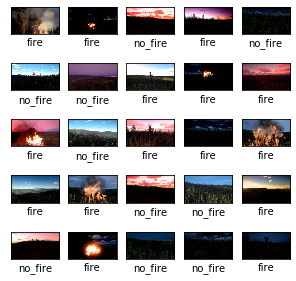

In [5]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = 5

    class_names = ['no_fire','fire']
    plt.figure(figsize=(5,5))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])

print('U5 Images: \n---------------')
plot_images(train_images, train_labels)

Test Real Images: 
---------------


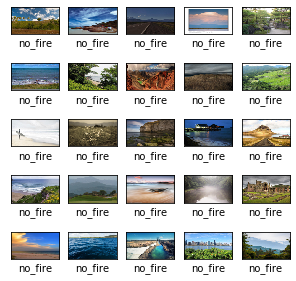

In [6]:
import random 
random.seed(42)
random.shuffle(test_data)
test_data_images, test_data_labels = zip(*test_data)
test_data_images = [np.array(Image.fromarray(img).convert('RGB')) for img in test_data_images]
test_data_images = np.array(test_data_images)/255

print('Test Real Images: \n---------------')
plot_images(test_data_images, test_data_labels)

In [7]:
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

,train_data_label,count_of_label
0,0,653
1,1,863


In [8]:
df = pd.DataFrame([label[0] for label in test_data_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['test_data_label', 'count_of_label']
df

,test_data_label,count_of_label
0,0,4319
1,1,45


In [9]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]

# Image Agmentation and Sample Model 

In [10]:
# initial model with augment layer

augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
        layers.RandomContrast(1.0, seed=100),
        ]

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history = model.fit(
  train_images,train_labels,
  validation_data=(test_images, test_labels),
  epochs=epochs
)

Epoch 1/10
48/48 [==============================] - 14s 283ms/step - loss: 0.6290 - accuracy: 0.6774 - val_loss: 0.5210 - val_accuracy: 0.7368
Epoch 2/10
48/48 [==============================] - 13s 280ms/step - loss: 0.5198 - accuracy: 0.7296 - val_loss: 0.4056 - val_accuracy: 0.8316
Epoch 3/10
48/48 [==============================] - 14s 287ms/step - loss: 0.4707 - accuracy: 0.7678 - val_loss: 0.3015 - val_accuracy: 0.8895
Epoch 4/10
48/48 [==============================] - 14s 286ms/step - loss: 0.3589 - accuracy: 0.8331 - val_loss: 0.5587 - val_accuracy: 0.7684
Epoch 5/10
48/48 [==============================] - 14s 290ms/step - loss: 0.4525 - accuracy: 0.7883 - val_loss: 0.4400 - val_accuracy: 0.7947
Epoch 6/10
48/48 [==============================] - 14s 289ms/step - loss: 0.3467 - accuracy: 0.8410 - val_loss: 0.2795 - val_accuracy: 0.8789
Epoch 7/10
48/48 [==============================] - 14s 291ms/step - loss: 0.3926 - accuracy: 0.8186 - val_loss: 0.2662 - val_accuracy: 0.8842

In [11]:
predictions = [model.predict(tf.expand_dims(img, 0)) for img in test_data_images[:50]]
scores = [tf.nn.softmax(prediction) for prediction in predictions]
pred_labels = [np.argmax(score) for score in scores]

In [12]:
true_labels = [i[0] for i in test_data_labels[:50]]

In [13]:
tf.math.confusion_matrix(true_labels, pred_labels[:50], 2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[13, 37],
       [ 0,  0]])>

In [14]:
#testing load model
model.save("artifacts/model.h5")
model = tf.keras.models.load_model('artifacts/model.h5')
width = model.input_shape[2]
height = model.input_shape[1]

print(width, height)

177 100


# Hyperparameter Tuning

In [15]:
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard
%reload_ext tensorboard
#! rm -rf ./logs/

In [29]:
session_num = 0
epochs = 50
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))#, 64])) #8, 16
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop']))#,'adam', 'Nadam'])) #'sgd','Adagrad'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []

test_data_images, test_data_labels = zip(*test_data)

# epochs = 50
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'} 88/91
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'} 88/93
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 16, 'dropout': 0.2, 'optimizer': 'RMSprop'} 84/91

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            units.append(num_units)
            dropouts.append(dropout_rate)
            optimizers.append(optimizer)
            run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                    HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER,
                    params, losses, accuracies, f1_scores, precisions, recalls, cms,
                    units, dropouts, optimizers, histories, augmentModel=True)
            session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'}
Epoch 1/50
10/48 [=====>........................] - ETA: 12s - loss: 1.2129 - accuracy: 0.4469 - f1_m: 0.5309 - precision_m: 0.4539 - recall_m: 0.6940

KeyboardInterrupt: 

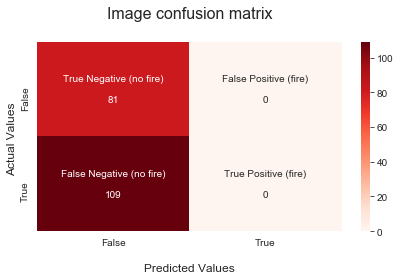

In [ ]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, f1_scores, precisions, recalls, cms)),#aucs, 
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'f1_scores', 'precisions', 'recalls', 'cms'])#'aucs',

modelDf['cms'].values[0]

plot_confusion_matrix_2(modelDf['cms'].values[0],normalize=False)

In [ ]:
line_chart(histories[0])

alt.Chart(...)

In [ ]:

history_df = pd.DataFrame(histories[0].history).reset_index()
history_df

,index,loss,accuracy,f1_m,precision_m,recall_m
0,0,0.70714,0.550792,0.7145,0.568331,0.982416


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i in range(len(list(modelDf.optimizers))):
    cls = modelDf.iloc[i,2]
    plot_confusion_matrix_2(modelDf[modelDf['optimizers']==cls]['cms'][i])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()